In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [ ]:
def min_max_scale(df, global_min, global_max, exclude_cols=[]):
    scaled_df = df.copy()
    for col in df.columns:
        if col not in exclude_cols:
            scaled_df[col] = (df[col] - global_min) / (global_max - global_min)
    return scaled_df

def create_3by5_list(dataframe):
    images = []
    for _, row in dataframe.iterrows():
        # 3x5 grid for each image representing the sensor layout
        image = np.zeros((3, 5))

        image[0, 0] = row['F7 (V)']
        image[0, 2] = row['F0 (V)']
        image[0, 4] = row['F1 (V)']
        image[1, 1] = row['F6 (V)']
        image[1, 3] = row['F2 (V)']
        image[2, 0] = row['F5 (V)']
        image[2, 2] = row['F4 (V)']
        image[2, 4] = row['F3 (V)']

        images.append(image)

    # Convert the list of images to a DataFrame
    images_df = pd.DataFrame({'Image': images})

    return images_df

def create_2by4_list(dataframe):
    images = []
    for _, row in dataframe.iterrows():
        # 2x4 grid for each image representing the sensor layout
        image = np.zeros((2, 4))

        image[0, 0] = row['F0 (V)']  # first sensor
        image[0, 1] = row['F1 (V)']
        image[0, 2] = row['F2 (V)']
        image[0, 3] = row['F3 (V)']
        image[1, 0] = row['F4 (V)']
        image[1, 1] = row['F5 (V)']
        image[1, 2] = row['F6 (V)']
        image[1, 3] = row['F7 (V)']

        images.append(image)

    # Convert the list of images to a DataFrame
    images_df = pd.DataFrame({'Image': images})

    return images_df

def create_timeseries_list(dataframe, window_duration=0.5, num_points=200):
    num_sensors = 8
    images = []

    # dataframe['Time (s)'] = dataframe['Time (s)'].astype(float)

    # Sort dataframe by time
    # dataframe = dataframe.sort_values('Time (s)').reset_index(drop=True)

    # Calculate the total number of data points in the dataframe
    total_time_points = len(dataframe)
    # print(f"total time points: {total_time_points}")

    # Calculate the step size for overlapping windows
    step_size = num_points // 2

    # Loop through the dataframe with the given step size
    for start_idx in range(0, total_time_points - step_size + 1, step_size):
        end_idx = start_idx + num_points

        # Handle the case where the final window may be smaller than num_points
        if end_idx > total_time_points:
            window = dataframe.iloc[start_idx:]
            if len(window) < num_points:
                continue
        else:
            window = dataframe.iloc[start_idx:end_idx]

        # Initialize the image array with zeros
        image = np.zeros((num_sensors, num_points))

        # Print the range of indices for the current window
        # print(f"Window {len(images) + 1}: Start index = {start_idx}, End index = {end_idx}")

        # Populate the image array with sensor data
        for j in range(num_points):
            time_sec = j * window_duration  # Time in seconds
            time_index = int(time_sec / window_duration)  # Calculate column index

            if time_index < len(window):
                image[0, j] = window.iloc[time_index]['F0 (V)']
                image[1, j] = window.iloc[time_index]['F1 (V)']
                image[2, j] = window.iloc[time_index]['F2 (V)']
                image[3, j] = window.iloc[time_index]['F3 (V)']
                image[4, j] = window.iloc[time_index]['F4 (V)']
                image[5, j] = window.iloc[time_index]['F5 (V)']
                image[6, j] = window.iloc[time_index]['F6 (V)']
                image[7, j] = window.iloc[time_index]['F7 (V)']

        images.append(image)

    # Convert the list of images to a DataFrame
    images_df = pd.DataFrame({'Image': images})

    return images_df

# Usage example
# images_df = create_timeseries_list(dataframe)

In [ ]:
GLOBAL_MIN = 0.45
GLOBAL_MAX = 1.5

def read_csv_files(exclude_cols, baseline, folder_path = '/content/drive/MyDrive/Research'):

  # Use glob to find all CSV files in the specified folder
  file_paths = glob.glob(os.path.join(folder_path, '*.csv'))
  # print(file_paths)

  first_list = []
  second_list = []
  third_list = []

  label = ''

  for file_path in file_paths:
    if file_path.endswith('.csv'):
      df = pd.read_csv(file_path)
      if 'good' in file_path:
          df['Label'] = 'good'
          label = 'good'
      elif 'bad' in file_path:
        if 'left' in file_path:
          df['Label'] = 'bad_left'
          label = 'bad_left'
        elif 'right' in file_path:
          df['Label'] = 'bad_right'
          label = 'bad_right'
        elif 'front' in file_path:
          df['Label'] = 'bad_front'
          label = 'bad_front'
        elif 'back' in file_path:
          df['Label'] = 'bad_back'
          label = 'bad_back'
        else:
          df['Label'] = 'bad'
          label = 'bad'
          print("this is file_name:", file_path)
      else:
          df['Label'] = 'unknown'  # ?
          label = 'unknown'
    #df is the dataframe from the csv file

    # Find the index of the first row where any sensor value exceeds the baseline
    baseline_idx = df[(df[['F0 (V)', 'F1 (V)', 'F2 (V)', 'F3 (V)', 'F4 (V)', 'F5 (V)', 'F6 (V)', 'F7 (V)']] > baseline).any(axis=1)].index[0]

    # Slice the DataFrame from that index onward
    final_df = df.loc[baseline_idx:].reset_index(drop=True)

    # min max scaling
    final_df = min_max_scale(final_df, GLOBAL_MIN, GLOBAL_MAX, exclude_cols)
    # min_max_scale(final_df, GLOBAL_MIN, GLOBAL_MAX, exclude_cols)


    # concatenate for each dataframe
    first = create_3by5_list(final_df)
    first['Label'] = label
    first_list.append(first)

    second = create_2by4_list(final_df)
    second['Label'] = label
    second_list.append(second)

    # third = create_timeseries_list(final_df, window_duration=0.5, num_points=500)
    # third['Label'] = label
    # third_list.append(third)

  #combine here
  first = pd.concat(first_list, ignore_index=True)
  second = pd.concat(second_list, ignore_index=True)
  # third = pd.concat(third_list, ignore_index=True)

  # return three separate returns of the combinations
  return first, second

# first, second, third = read_csv_files(exclude_cols = ['Time (s)', 'Label'], baseline = 0.61)

In [ ]:
def save_df(df, filepath):
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory '{directory}' does not exist.")
    try:
        df.to_pickle(filepath)
        print(f"Dataframe successfully saved to: {filepath}")
    except Exception as e:
        print(f"Failed to save dataframe to {filepath}: {e}")

def load_df(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File path '{filepath}' does not exist.")
    try:
        return pd.read_pickle(filepath)
    except Exception as e:
        print(f"Failed to load dataframe from {filepath}: {e}")
        return None

**3x5 Image Total Data for Each Category**

all around the same

<Axes: xlabel='Label'>

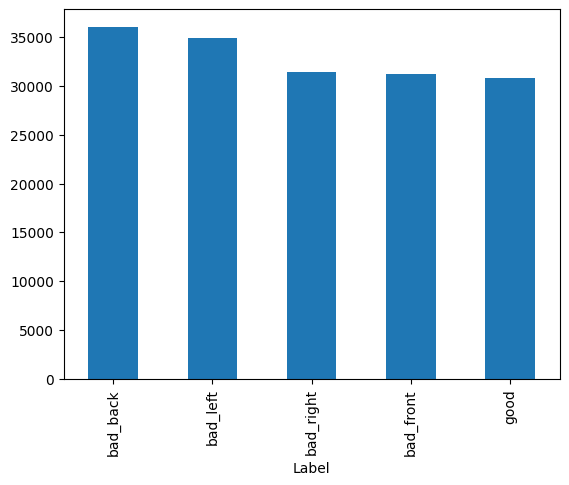

In [ ]:
# Load 3by5 df from pickle file
filepath = '/content/drive/MyDrive/Research/3by5_df1.pkl'
three_by_five_df = load_df(filepath)
three_by_five_df.Label.value_counts().plot(kind='bar')

In [ ]:
three_by_five_df

,Image,Label
0,"[[0.03809523809523808, 0.0, 0.0571428571428571...",good
1,"[[0.03809523809523808, 0.0, 0.0571428571428571...",good
2,"[[0.03809523809523808, 0.0, 0.0571428571428571...",good
3,"[[0.04761904761904761, 0.0, 0.0571428571428571...",good
4,"[[0.03809523809523808, 0.0, 0.0666666666666666...",good
...,...,...
164419,"[[0.04761904761904761, 0.0, 0.0380952380952380...",good
164420,"[[0.04761904761904761, 0.0, 0.0476190476190476...",good
164421,"[[0.03809523809523808, 0.0, 0.0476190476190476...",good
164422,"[[0.03809523809523808, 0.0, 0.0476190476190476...",good


In [ ]:
import numpy as np

# Flatten all the arrays/lists in the 'Image' column (assuming the arrays/lists are in a column named 'Image')
flattened_values = np.hstack(three_by_five_df['Image'].values)

# Find the maximum value
max_value = np.max(flattened_values)

print("Maximum value in the entire DataFrame:", max_value)

Maximum value in the entire DataFrame: 0.6285714285714287


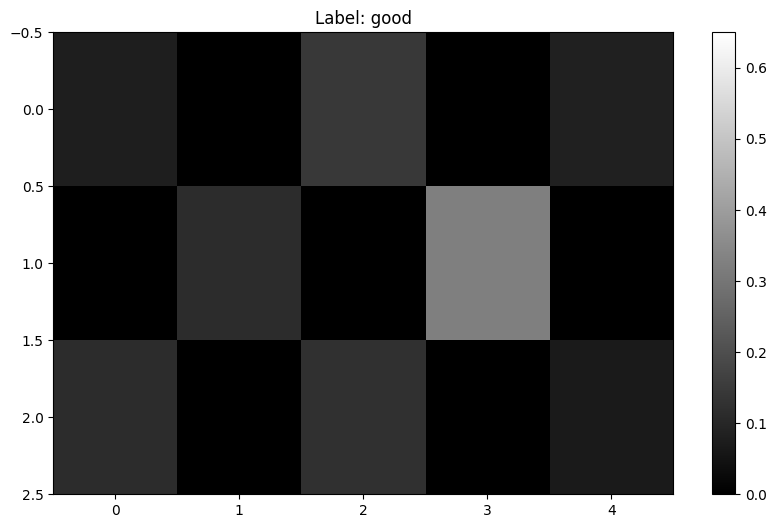

In [ ]:
def display_image_by_label(df, label, vmin=None, vmax=None):
    # Filter the dataframe based on the label
    filtered_df = df[df['Label'] == label]

    if filtered_df.empty:
        print(f"No images found with label '{label}'.")
        return

    # Select a random image from the filtered dataframe
    random_image = filtered_df.sample(n=1)['Image'].values[0]

    # Display the image
    plt.figure(figsize=(10, 6))  # Adjust the size as necessary
    plt.imshow(random_image, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    plt.title(f"Label: {label}")
    plt.colorbar()
    plt.show()

display_image_by_label(three_by_five_df, label='good', vmin=0, vmax=0.65)


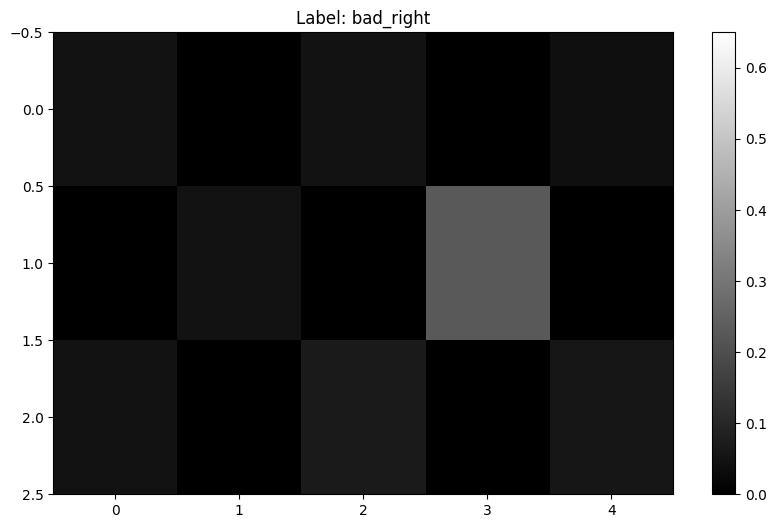

In [ ]:
display_image_by_label(three_by_five_df, label='bad_right', vmin=0, vmax=0.65)

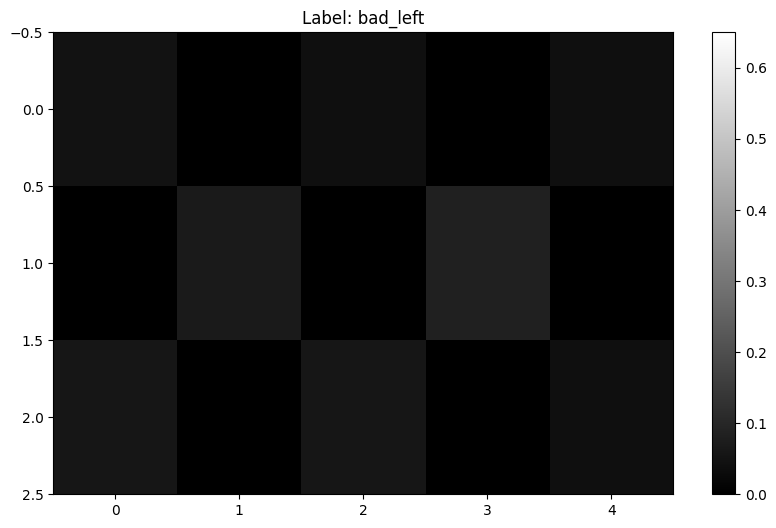

In [ ]:
display_image_by_label(three_by_five_df, label='bad_left', vmin=0, vmax=0.65)

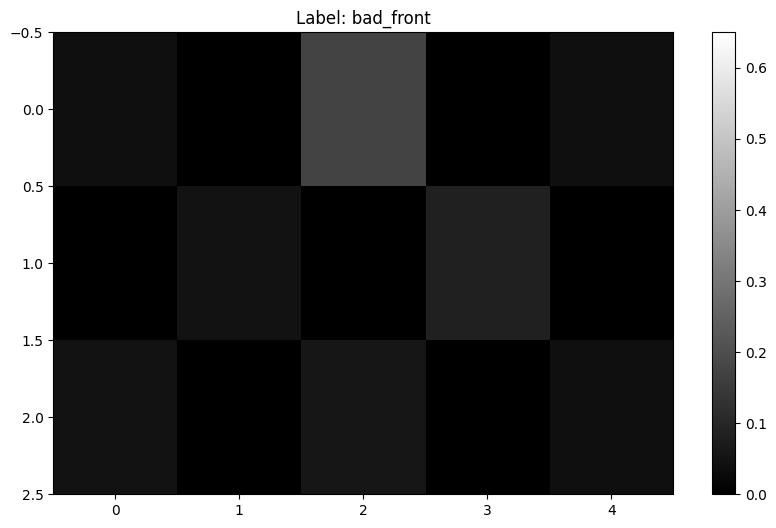

In [ ]:
display_image_by_label(three_by_five_df, label='bad_front', vmin=0, vmax=0.65)

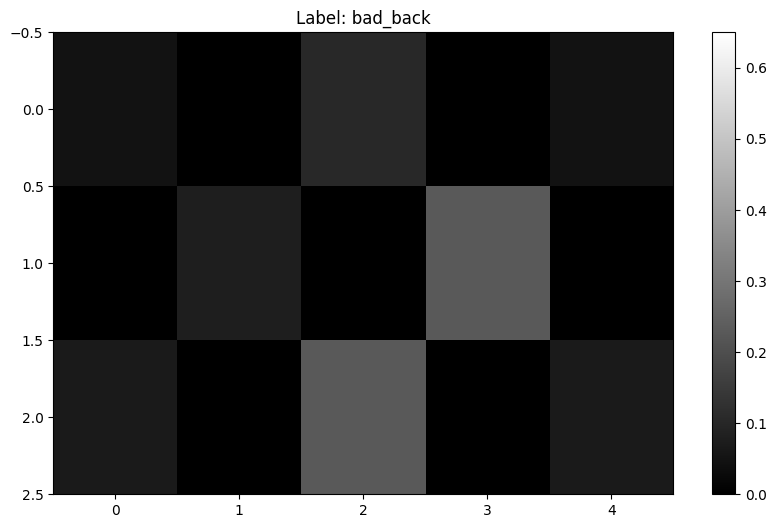

In [ ]:
display_image_by_label(three_by_five_df, label='bad_back', vmin=0, vmax=0.65)

# Example Data: Visualization of 3x5 input "image"

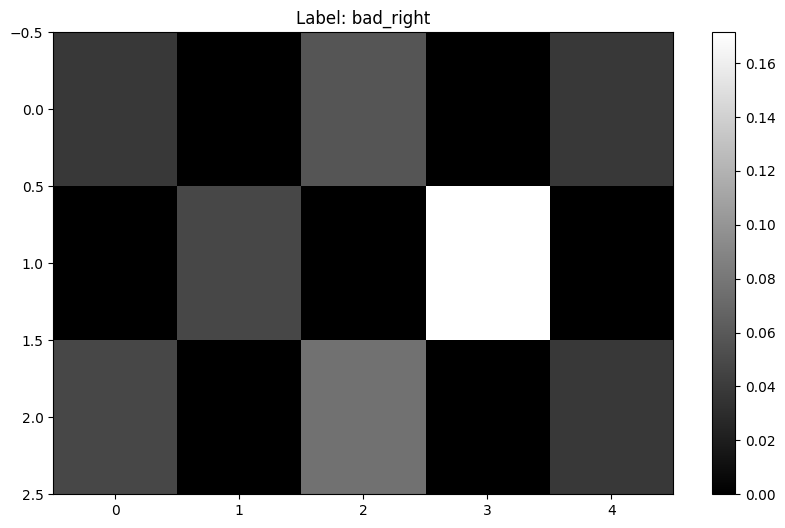

In [ ]:
import matplotlib.pyplot as plt

def display_image_by_label(df, label):
    # Filter the dataframe based on the label
    filtered_df = df[df['Label'] == label]

    if filtered_df.empty:
        print(f"No images found with label '{label}'.")
        return

    # Select a random image from the filtered dataframe
    random_image = filtered_df.sample(n=1)['Image'].values[0]

    # Display the image
    plt.figure(figsize=(10, 6))  # Adjust the size as necessary
    plt.imshow(random_image, cmap='gray', aspect='auto')
    plt.title(f"Label: {label}")
    plt.colorbar()
    plt.show()

display_image_by_label(three_by_five_df, "bad_right")


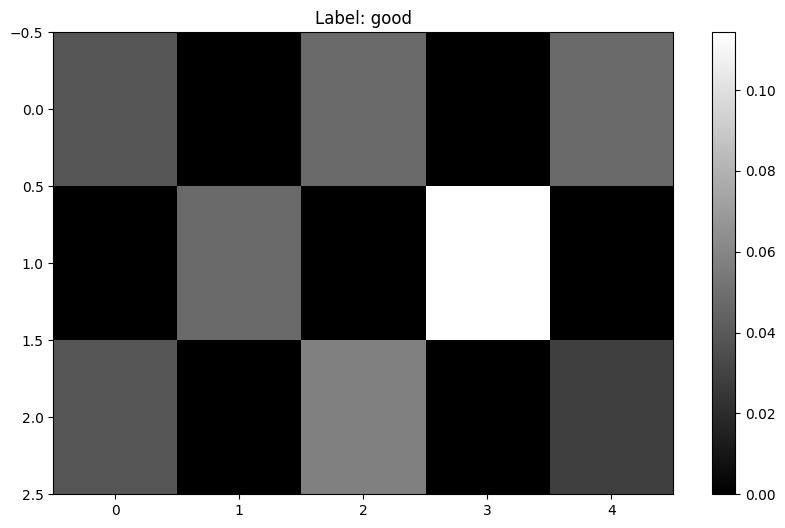

In [ ]:
display_image_by_label(three_by_five_df, "good")


# Model with SGD optimizer and decay learning rate



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = np.array(three_by_five_df['Image'].tolist())
Y = three_by_five_df["Label"]

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(Y)
labels_categorical = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, labels_categorical, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (131539, 3, 5)
y_train shape: (131539, 5)
X_test shape: (32885, 3, 5)
y_test shape: (32885, 5)


In [ ]:
# model using Functional API - 3 by 5 - using padding and smaller filter size
import tensorflow.keras as keras

batch_size = 32

inputs = Input(shape=(3, 5, 1))
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)  # First conv layer
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor to feed it to dense layer
x = Dense(64, activation='relu')(x)  # Fully connected layer
outputs = Dense(5, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
# no learning rate

initial_lr = 0.001
decay_rate = 0.96
decay_steps = len(X_train) // batch_size  # decay every epoch

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum = .9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 5, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 5, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,733 (123.96 KB)

 Trainable params: 31,733 (123.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=200, batch_size = 32, validation_split=0.2, callbacks=[callback])
if history is None:
    raise ValueError("The model training did not return a valid history object.")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.3017 - loss: 1.5905 - val_accuracy: 0.5109 - val_loss: 1.4527
Epoch 2/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5497 - loss: 1.2699 - val_accuracy: 0.6315 - val_loss: 0.9053
Epoch 3/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6360 - loss: 0.8578 - val_accuracy: 0.6534 - val_loss: 0.7809
Epoch 4/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6743 - loss: 0.7570 - val_accuracy: 0.6922 - val_loss: 0.7150
Epoch 5/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6946 - loss: 0.7027 - val_accuracy: 0.7040 - val_loss: 0.6896
Epoch 6/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7063 - loss: 0.6681 - val_accuracy: 0.7100 - val_loss: 0.6488
Epoch 7/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7169 - loss: 0.6437 - val_accuracy: 0.7250 - val_loss: 0.6302
Epoch 8/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7320 - lo

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 5, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 5, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,467 (247.92 KB)

 Trainable params: 31,733 (123.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,734 (123.96 KB)

5139/5139 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


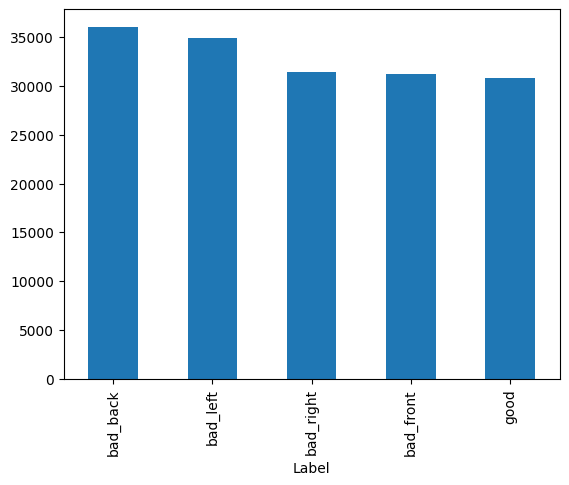

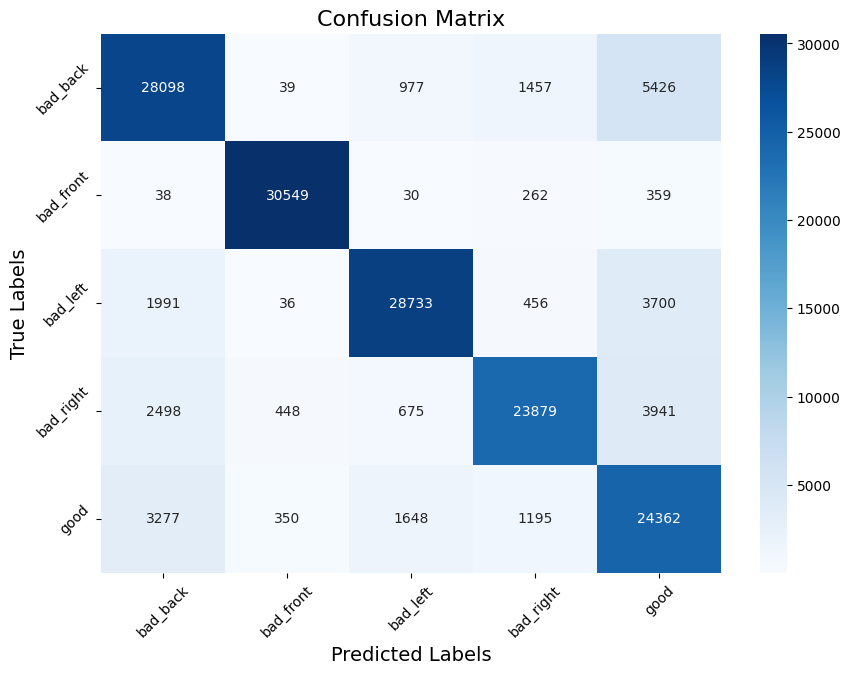

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.78      0.78      0.78     35997
   bad_front       0.97      0.98      0.98     31238
    bad_left       0.90      0.82      0.86     34916
   bad_right       0.88      0.76      0.81     31441
        good       0.64      0.79      0.71     30832

    accuracy                           0.82    164424
   macro avg       0.83      0.83      0.83    164424
weighted avg       0.83      0.82      0.83    164424



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def test_data(model, label_encoder):
      # Plotting the distribution of labels in the unseen data
      three_by_five_df.Label.value_counts().plot(kind='bar')

      # Prepare the unseen data
      X_unseen = np.array(three_by_five_df['Image'].tolist())
      Y_unseen = three_by_five_df["Label"]

      # Encode and categorize the labels
      labels_encoded = label_encoder.transform(Y_unseen)
      labels_categorical = to_categorical(labels_encoded)

      # Predict using the model
      y_pred_prob = model.predict(X_unseen.reshape(-1, 3, 5, 1))
      y_pred = np.argmax(y_pred_prob, axis=1)
      y_true = np.argmax(labels_categorical, axis=1)


      labels_guessed = list(set(np.concatenate((y_pred, y_true))))

      # Confusion Matrix
      confusion = confusion_matrix(y_true, y_pred)

      # Plot Confusion Matrix
      plt.figure(figsize=(10, 7))
      sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
      plt.title("Confusion Matrix", fontsize=16)
      plt.xlabel('Predicted Labels', fontsize=14)
      plt.ylabel('True Labels', fontsize=14)
      plt.xticks(rotation=45)
      plt.yticks(rotation=45)
      plt.show()

      # Classification Report
      print(labels_guessed)
      report = classification_report(y_true, y_pred, labels=labels_guessed, target_names=label_encoder.classes_, zero_division=0)
      print("Classification Report:")
      print(report)

test_data(model, label_encoder)

683/683 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


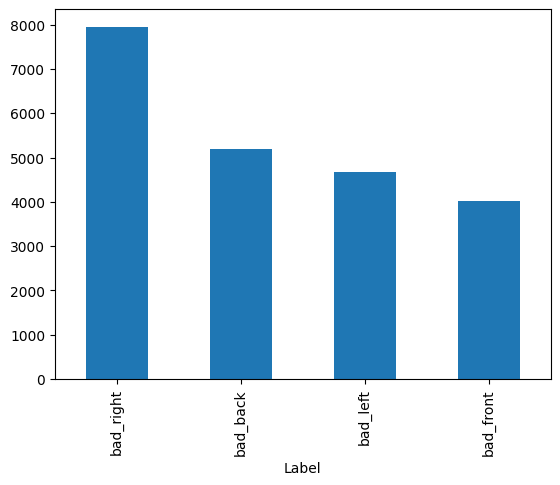

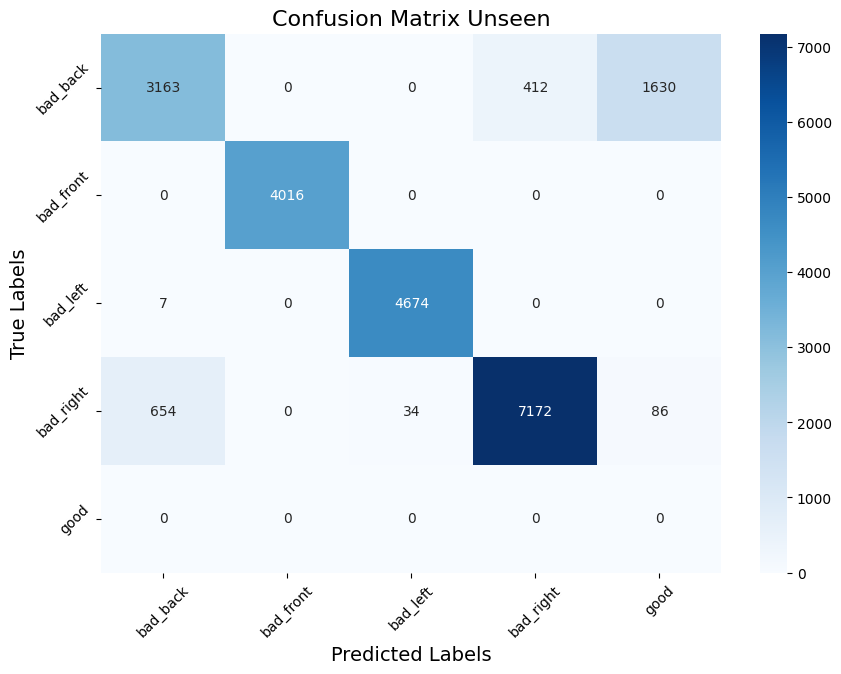

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.83      0.61      0.70      5205
   bad_front       1.00      1.00      1.00      4016
    bad_left       0.99      1.00      1.00      4681
   bad_right       0.95      0.90      0.92      7946
        good       0.00      0.00      0.00         0

    accuracy                           0.87     21848
   macro avg       0.75      0.70      0.72     21848
weighted avg       0.94      0.87      0.90     21848



In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Medium Circle', model, label_encoder)

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


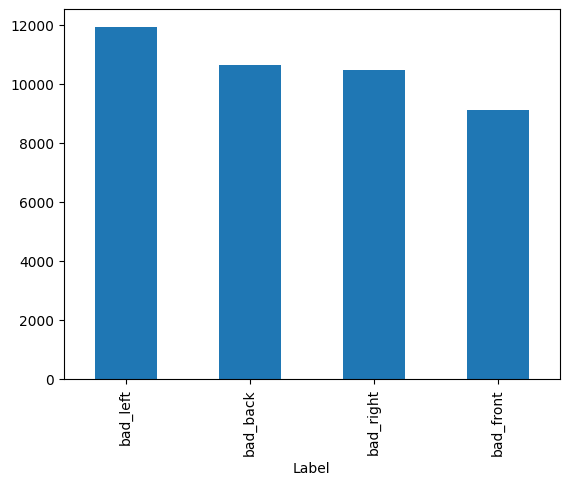

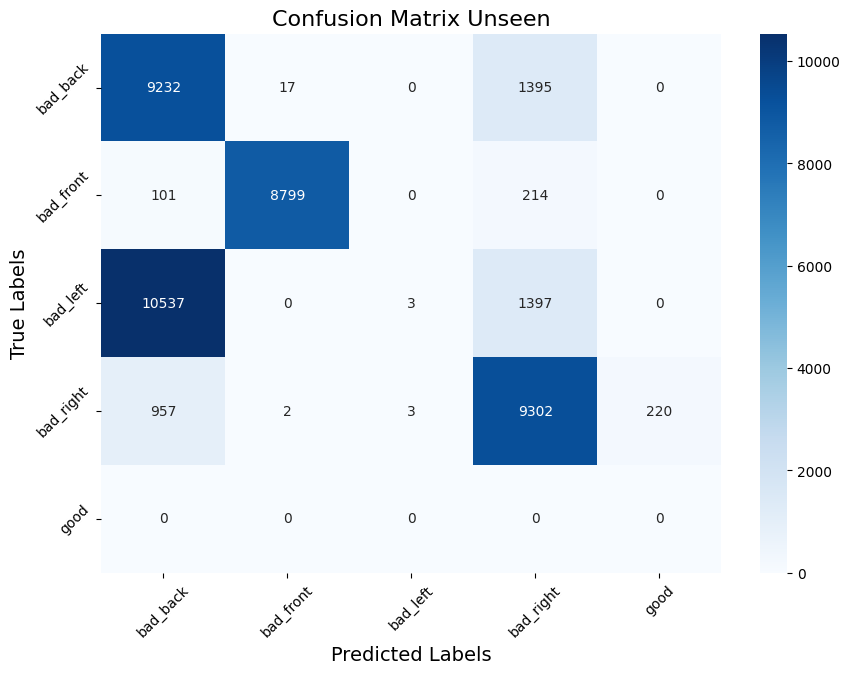

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.44      0.87      0.59     10644
   bad_front       1.00      0.97      0.98      9114
    bad_left       0.50      0.00      0.00     11937
   bad_right       0.76      0.89      0.82     10484
        good       0.00      0.00      0.00         0

    accuracy                           0.65     42179
   macro avg       0.54      0.54      0.48     42179
weighted avg       0.66      0.65      0.56     42179



In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Large Ellipse', model, label_encoder)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(3, 5, 1))

# First conv layer with batch normalization
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)

# Second conv layer with batch normalization
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Flatten the tensor to feed it to dense layer
x = Flatten()(x)

# Fully connected layer with batch normalization and dropout
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for 5 classes
outputs = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 5, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 5, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,733 (123.96 KB)

 Trainable params: 31,733 (123.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
if history is None:
    raise ValueError("The model training did not return a valid history object.")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6450 - loss: 0.8702 - val_accuracy: 0.7888 - val_loss: 0.5106
Epoch 2/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7814 - loss: 0.5303 - val_accuracy: 0.8067 - val_loss: 0.4768
Epoch 3/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7985 - loss: 0.4960 - val_accuracy: 0.8196 - val_loss: 0.4573
Epoch 4/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8054 - loss: 0.4842 - val_accuracy: 0.8196 - val_loss: 0.4497
Epoch 5/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8075 - loss: 0.4777 - val_accuracy: 0.8218 - val_loss: 0.4448
Epoch 6/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8104 - loss: 0.4718 - val_accuracy: 0.8209 - val_loss: 0.4449
Epoch 7/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8119 - loss: 0.4664 - val_accuracy: 0.8212 - val_loss: 0.4418
Epoch 8/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8138 - loss: 0.

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 5, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 5, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,201 (371.88 KB)

 Trainable params: 31,733 (123.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,468 (247.93 KB)

5139/5139 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step


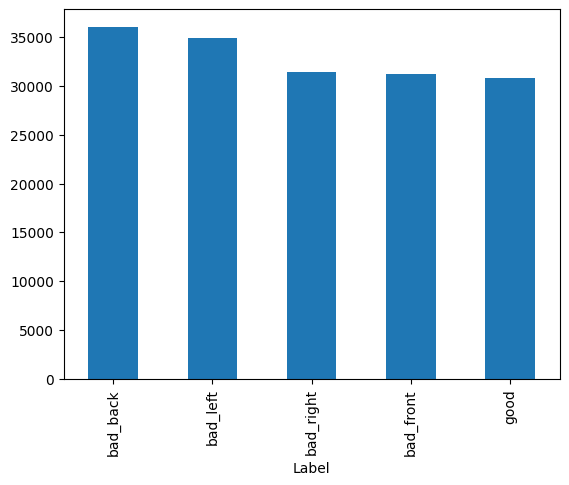

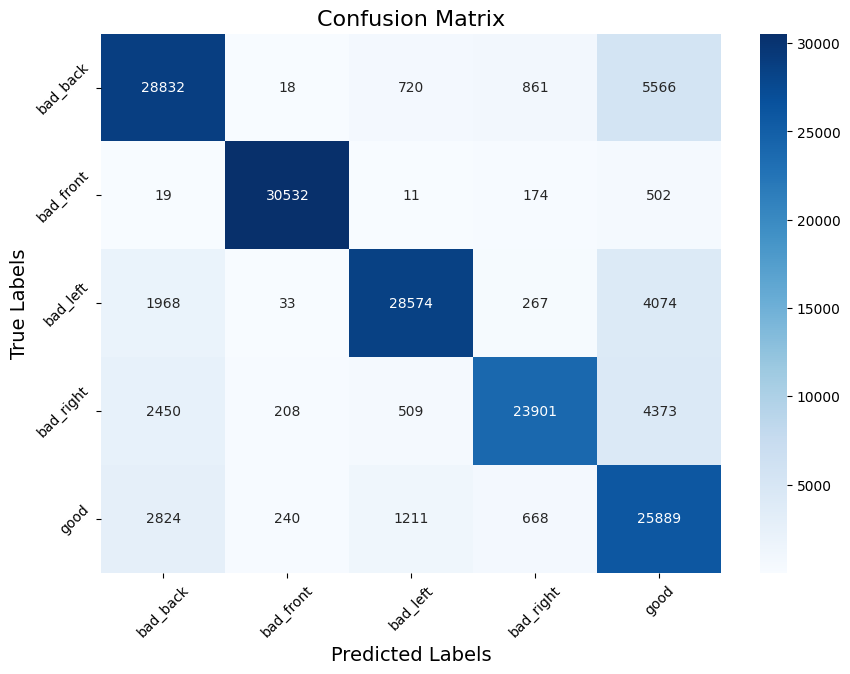

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.80      0.80      0.80     35997
   bad_front       0.98      0.98      0.98     31238
    bad_left       0.92      0.82      0.87     34916
   bad_right       0.92      0.76      0.83     31441
        good       0.64      0.84      0.73     30832

    accuracy                           0.84    164424
   macro avg       0.85      0.84      0.84    164424
weighted avg       0.85      0.84      0.84    164424



In [ ]:
test_data(model, label_encoder)

683/683 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


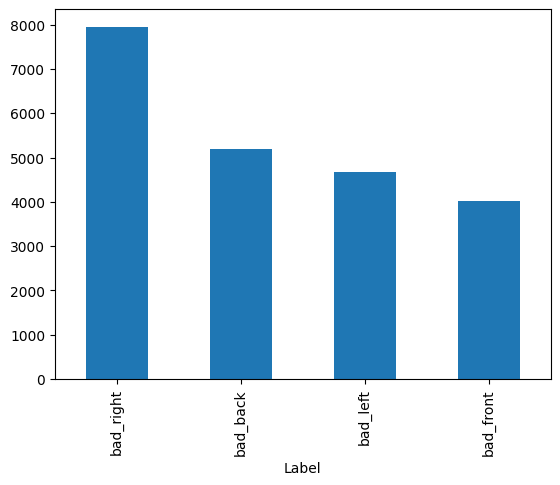

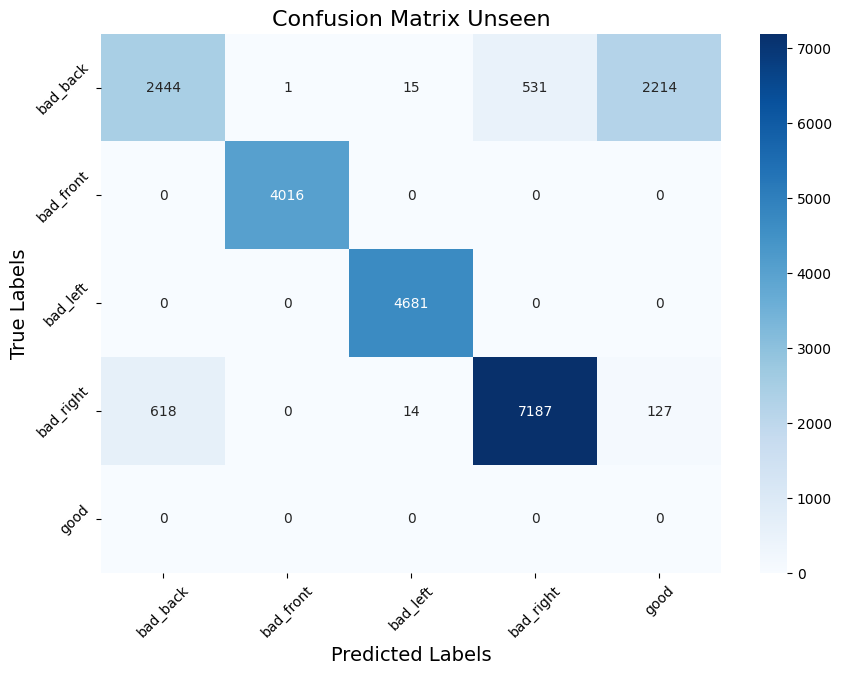

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.80      0.47      0.59      5205
   bad_front       1.00      1.00      1.00      4016
    bad_left       0.99      1.00      1.00      4681
   bad_right       0.93      0.90      0.92      7946
        good       0.00      0.00      0.00         0

    accuracy                           0.84     21848
   macro avg       0.74      0.67      0.70     21848
weighted avg       0.93      0.84      0.87     21848



In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Medium Circle', model, label_encoder)

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


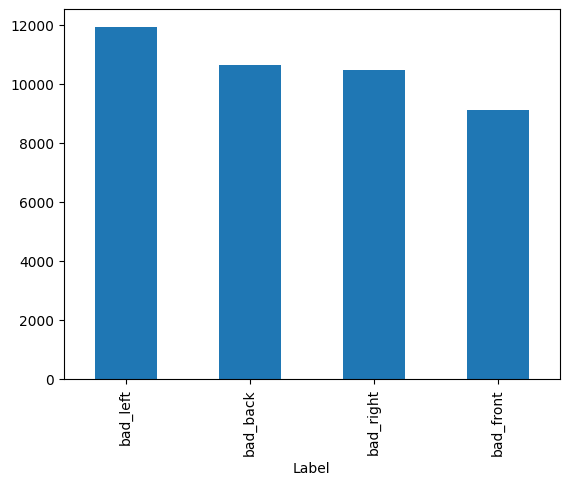

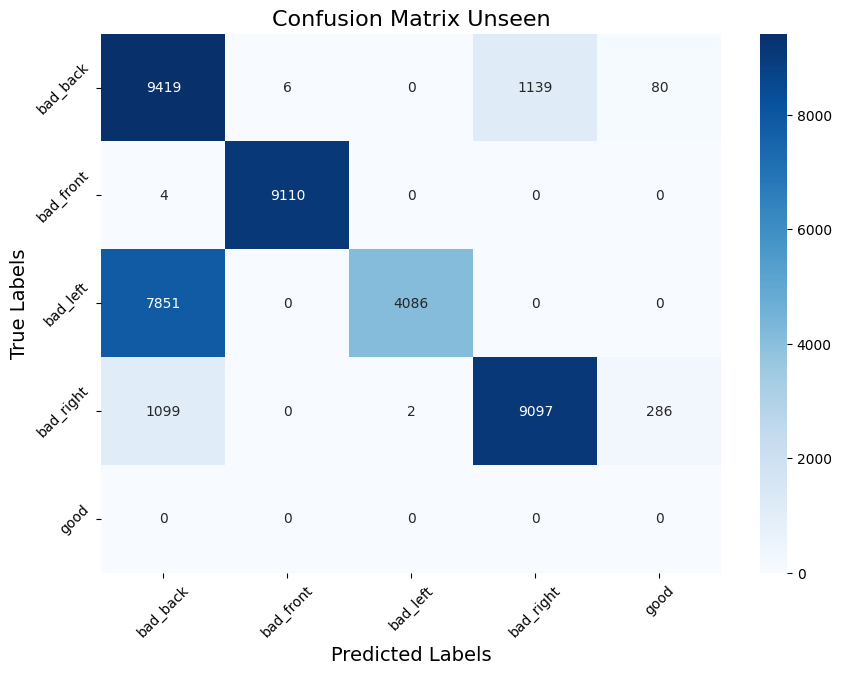

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.51      0.88      0.65     10644
   bad_front       1.00      1.00      1.00      9114
    bad_left       1.00      0.34      0.51     11937
   bad_right       0.89      0.87      0.88     10484
        good       0.00      0.00      0.00         0

    accuracy                           0.75     42179
   macro avg       0.68      0.62      0.61     42179
weighted avg       0.85      0.75      0.74     42179



In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Large Ellipse', model, label_encoder)

# Initial Model

In [ ]:
# model using Functional API - 3 by 5 - using padding and smaller filter size

inputs = Input(shape=(3, 5, 1))
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)  # First conv layer
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor to feed it to dense layer
x = Dense(64, activation='relu')(x)  # Fully connected layer
outputs = Dense(5, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
# no learning rate
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 5, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 5, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,733 (123.96 KB)

 Trainable params: 31,733 (123.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
if history is None:
    raise ValueError("The model training did not return a valid history object.")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6500 - loss: 0.8592 - val_accuracy: 0.7740 - val_loss: 0.5566
Epoch 2/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7827 - loss: 0.5379 - val_accuracy: 0.7960 - val_loss: 0.5035
Epoch 3/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8018 - loss: 0.4902 - val_accuracy: 0.8145 - val_loss: 0.4664
Epoch 4/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8068 - loss: 0.4764 - val_accuracy: 0.7971 - val_loss: 0.4881
Epoch 5/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8158 - loss: 0.4586 - val_accuracy: 0.8169 - val_loss: 0.4537
Epoch 6/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8179 - loss: 0.4543 - val_accuracy: 0.8172 - val_loss: 0.4506
Epoch 7/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8193 - loss: 0.4488 - val_accuracy: 0.8218 - val_loss: 0.4410
Epoch 8/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8191 - loss: 0.

5139/5139 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step


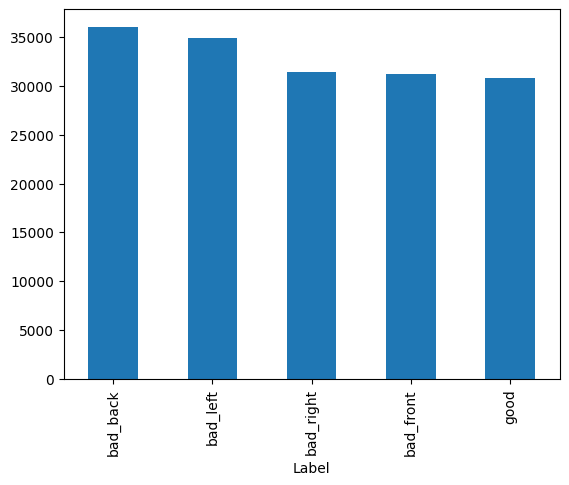

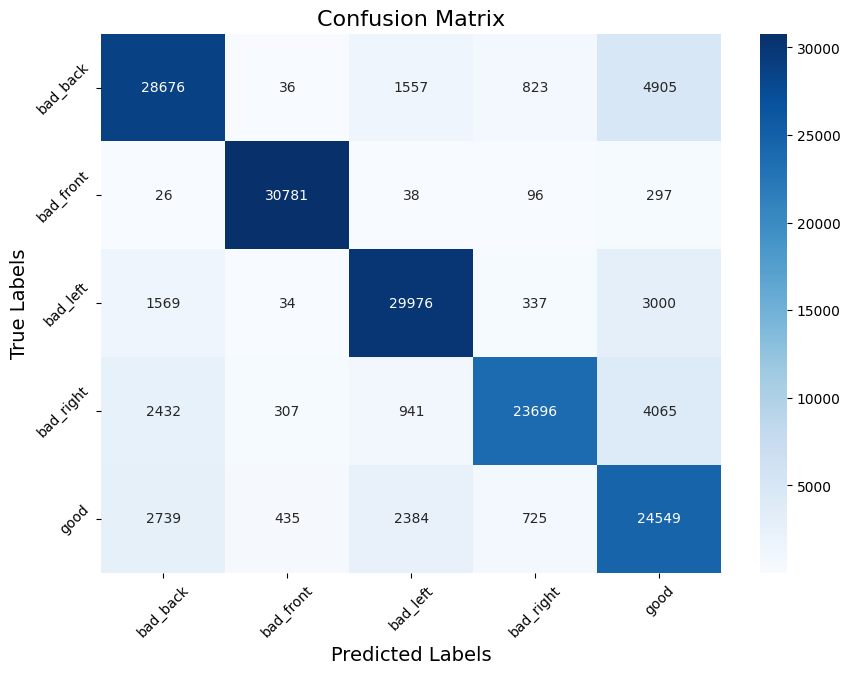

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.81      0.80      0.80     35997
   bad_front       0.97      0.99      0.98     31238
    bad_left       0.86      0.86      0.86     34916
   bad_right       0.92      0.75      0.83     31441
        good       0.67      0.80      0.73     30832

    accuracy                           0.84    164424
   macro avg       0.85      0.84      0.84    164424
weighted avg       0.85      0.84      0.84    164424



In [ ]:
test_data(model, label_encoder)

683/683 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


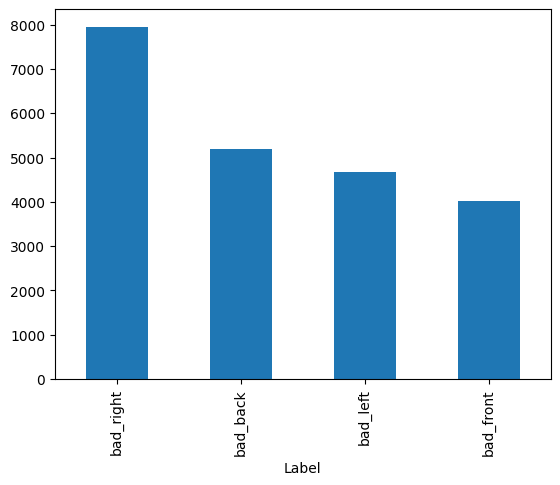

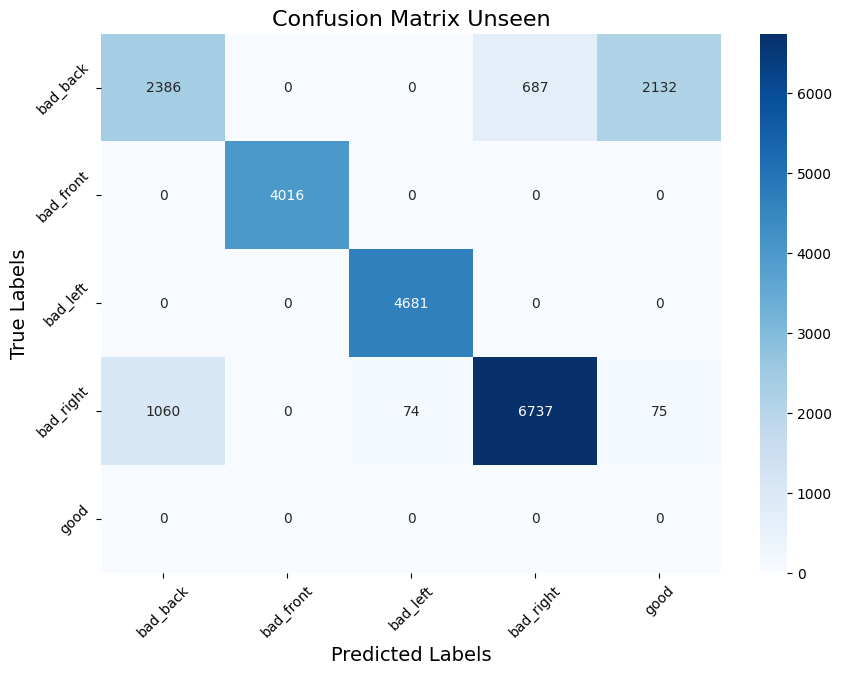

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.69      0.46      0.55      5205
   bad_front       1.00      1.00      1.00      4016
    bad_left       0.98      1.00      0.99      4681
   bad_right       0.91      0.85      0.88      7946
        good       0.00      0.00      0.00         0

    accuracy                           0.82     21848
   macro avg       0.72      0.66      0.68     21848
weighted avg       0.89      0.82      0.85     21848



In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Medium Circle', model, label_encoder)

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


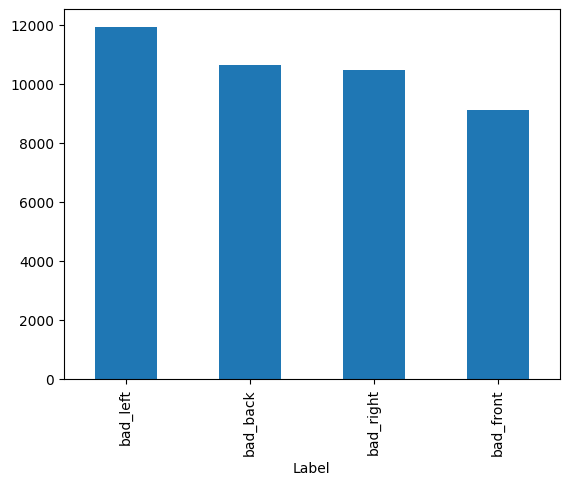

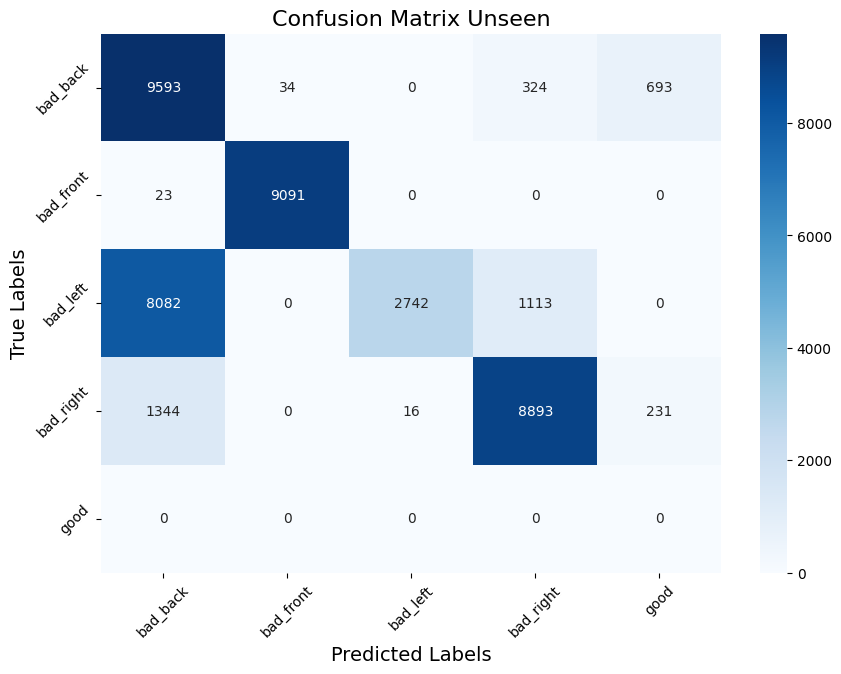

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.50      0.90      0.65     10644
   bad_front       1.00      1.00      1.00      9114
    bad_left       0.99      0.23      0.37     11937
   bad_right       0.86      0.85      0.85     10484
        good       0.00      0.00      0.00         0

    accuracy                           0.72     42179
   macro avg       0.67      0.60      0.57     42179
weighted avg       0.84      0.72      0.70     42179



In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Large Ellipse', model, label_encoder)

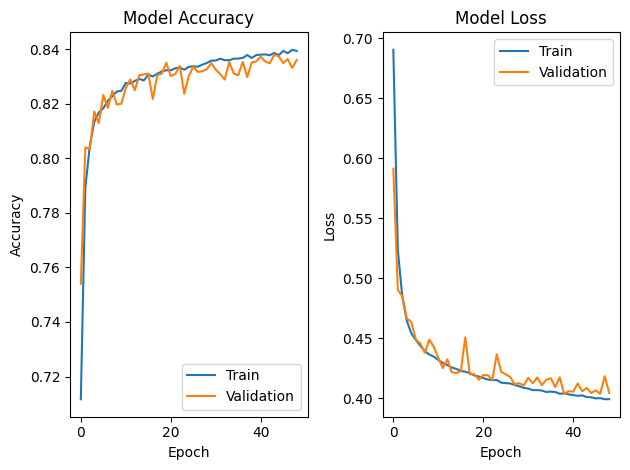

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

y_pred_prob = model.predict(X_test.reshape(-1, 3, 5, 1))  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
labels = label_encoder.classes_
print(labels)

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Plotting the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Adding labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Rotate the x and y labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

1028/1028 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
['bad_back' 'bad_front' 'bad_left' 'bad_right']


ValueError: Number of classes, 5, does not match size of target_names, 4. Try specifying the labels parameter

In [ ]:
folder_path = '/content/drive/MyDrive/Research/Unseen Data Medium Circle'
first, second = read_csv_files(exclude_cols = ['Time (s)', 'Label'], baseline = 0.6, folder_path=folder_path)

<Axes: xlabel='Label'>

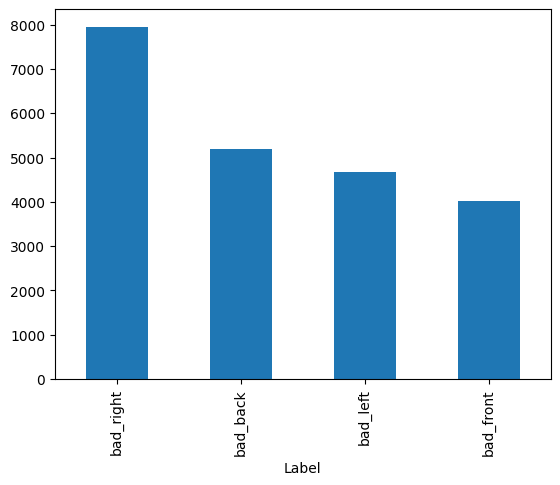

In [ ]:
first.Label.value_counts().plot(kind='bar')

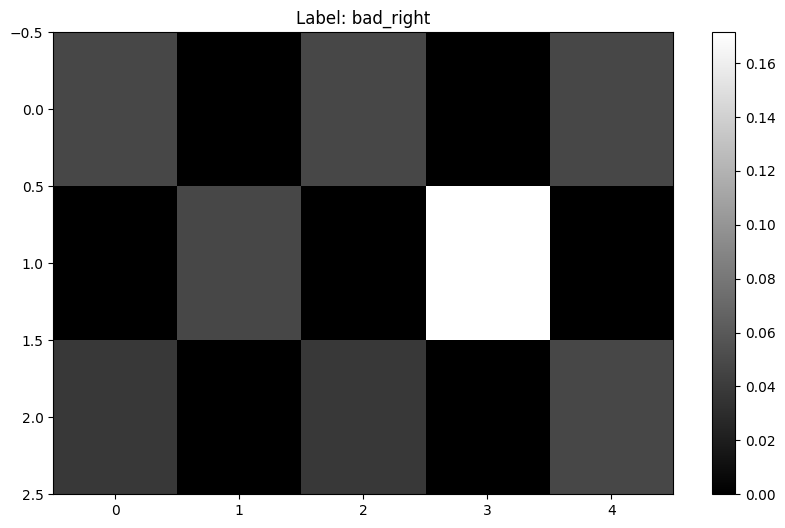

In [ ]:
display_image_by_label(first, "bad_right")

In [ ]:
X_unseen = np.array(first['Image'].tolist())
Y_unseen = first["Label"]
labels_encoded = label_encoder.fit_transform(Y_unseen)
labels_categorical = to_categorical(labels_encoded)

y_pred_prob = model.predict(X_unseen.reshape(-1, 3, 5, 1))  # Predicted probabilities


683/683 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def test_unseen_data(filepath, model, label_encoder):

      # Read the CSV files while excluding specific columns
      first, second = read_csv_files(exclude_cols=['Time (s)', 'Label'], baseline=0.6, folder_path=filepath)

      if first.empty:
          print("No data found in the provided path.")
          return

      # Plotting the distribution of labels in the unseen data
      first.Label.value_counts().plot(kind='bar')

      # Prepare the unseen data
      X_unseen = np.array(first['Image'].tolist())
      Y_unseen = first["Label"]

      # Encode and categorize the labels
      labels_encoded = label_encoder.transform(Y_unseen)
      labels_categorical = to_categorical(labels_encoded)

      # Predict using the model
      y_pred_prob = model.predict(X_unseen.reshape(-1, 3, 5, 1))
      y_pred = np.argmax(y_pred_prob, axis=1)
      y_true = np.argmax(labels_categorical, axis=1)


      labels_guessed = list(set(np.concatenate((y_pred, y_true))))

      # Confusion Matrix
      confusion = confusion_matrix(y_true, y_pred)

      # Plot Confusion Matrix
      plt.figure(figsize=(10, 7))
      sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
      plt.title("Confusion Matrix Unseen", fontsize=16)
      plt.xlabel('Predicted Labels', fontsize=14)
      plt.ylabel('True Labels', fontsize=14)
      plt.xticks(rotation=45)
      plt.yticks(rotation=45)
      plt.show()

      # Classification Report
      print(labels_guessed)
      report = classification_report(y_true, y_pred, labels=labels_guessed, target_names=label_encoder.classes_, zero_division=0)
      print("Classification Report:")
      print(report)

683/683 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


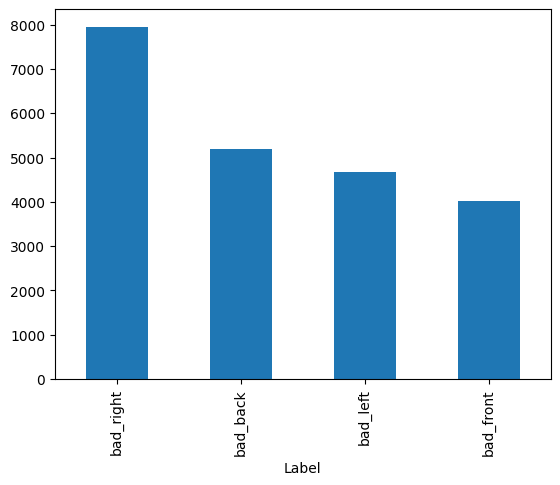

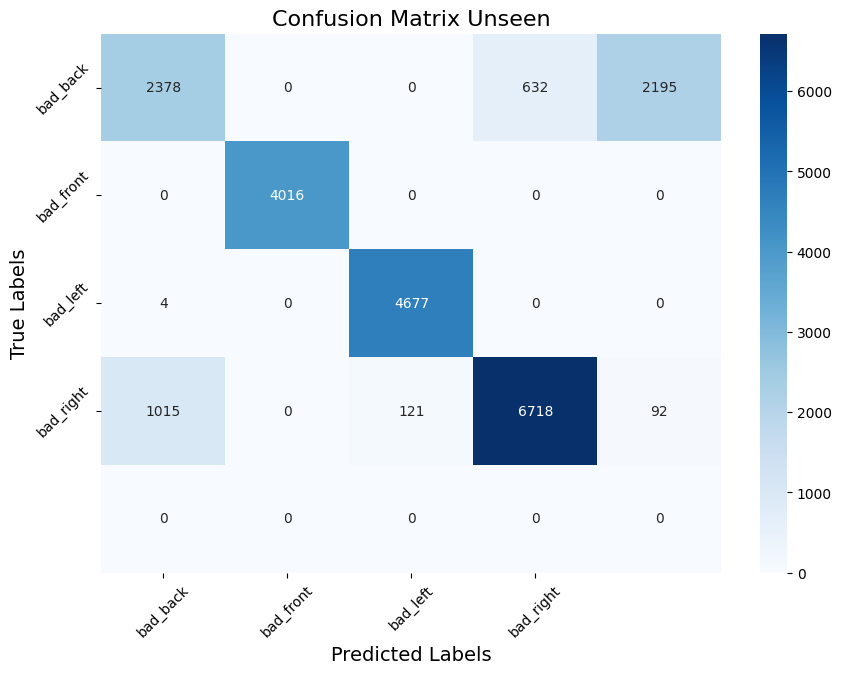

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.70      0.46      0.55      5205
   bad_front       1.00      1.00      1.00      4016
    bad_left       0.97      1.00      0.99      4681
   bad_right       0.91      0.85      0.88      7946

    accuracy                           0.81     21848
   macro avg       0.72      0.66      0.68     21848
weighted avg       0.89      0.81      0.85     21848



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2561: UserWarning: labels size, 5, does not match size of target_names, 4
  warnings.warn(


In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Medium Circle', model, label_encoder)

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


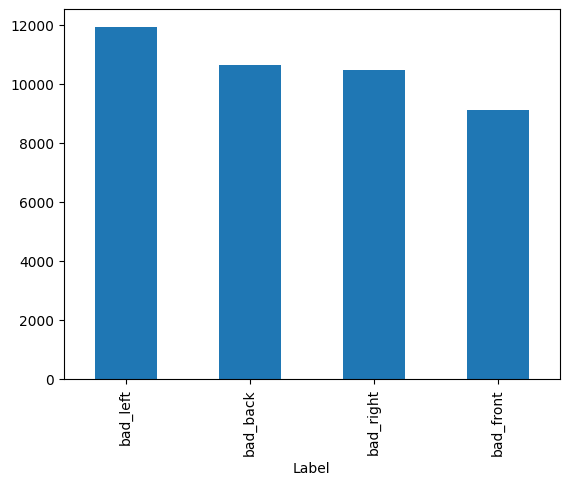

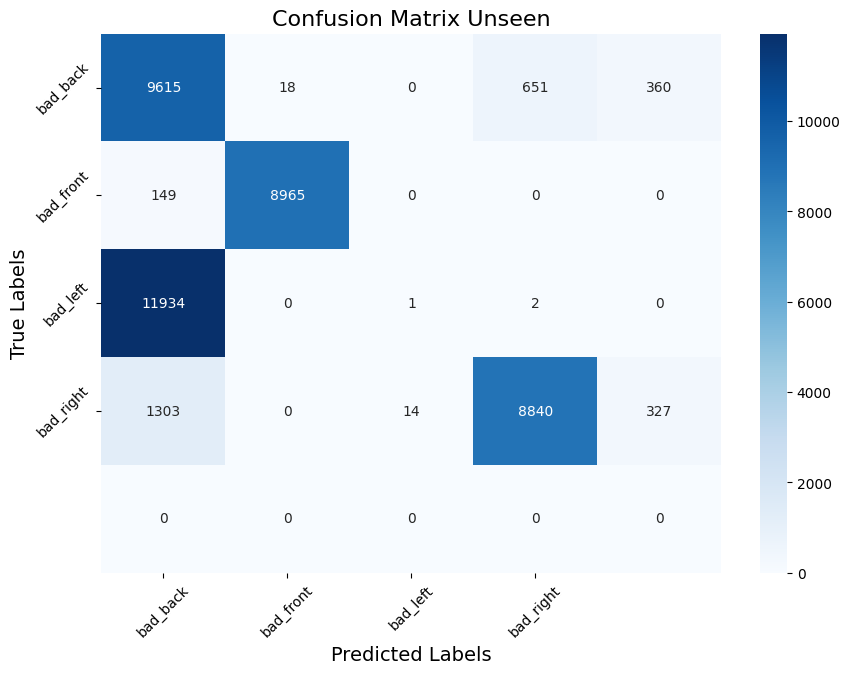

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.42      0.90      0.57     10644
   bad_front       1.00      0.98      0.99      9114
    bad_left       0.07      0.00      0.00     11937
   bad_right       0.93      0.84      0.89     10484

    accuracy                           0.65     42179
   macro avg       0.48      0.55      0.49     42179
weighted avg       0.57      0.65      0.58     42179



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2561: UserWarning: labels size, 5, does not match size of target_names, 4
  warnings.warn(


In [ ]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Large Ellipse', model, label_encoder)

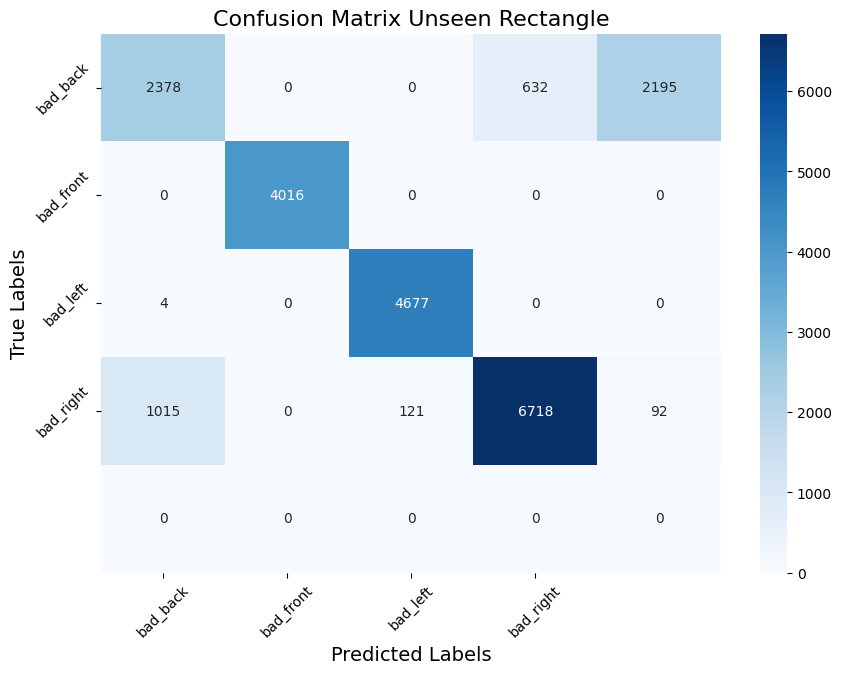

ValueError: Number of classes, 5, does not match size of target_names, 4. Try specifying the labels parameter

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(labels_categorical, axis=1)

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Unseen Rectangle", fontsize= 16)
# Adding labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
# Rotate the x and y labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print("Classification Report:")
print(report)

# Unseen Data

In [ ]:
folder_path = '/content/drive/MyDrive/Research/Unseen Data'
first, second = read_csv_files(exclude_cols = ['Time (s)', 'Label'], baseline = 0.6, folder_path=folder_path)

<Axes: xlabel='Label'>

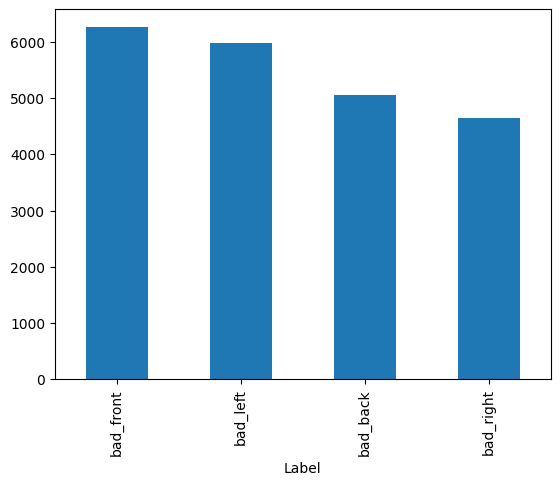

In [ ]:
first.Label.value_counts().plot(kind='bar')

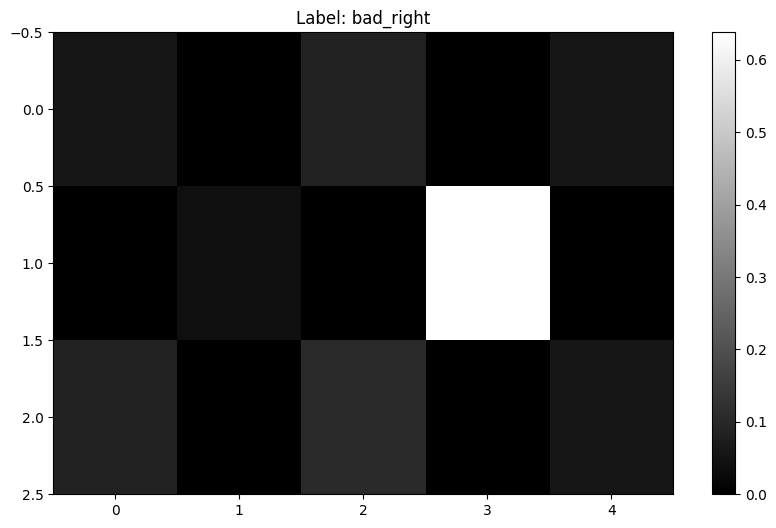

In [ ]:
display_image_by_label(first, "bad_right")

In [ ]:
unique_labels = first['Label'].unique()
print("Unique categories in 'label' column:", unique_labels)

Unique categories in 'label' column: ['bad_front' 'bad_left' 'bad_right' 'bad_back']


In [ ]:
X_unseen = np.array(first['Image'].tolist())
Y_unseen = first["Label"]
labels_encoded = label_encoder.fit_transform(Y_unseen)
labels_categorical = to_categorical(labels_encoded)

y_pred_prob = model.predict(X_unseen.reshape(-1, 3, 5, 1))  # Predicted probabilities


686/686 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


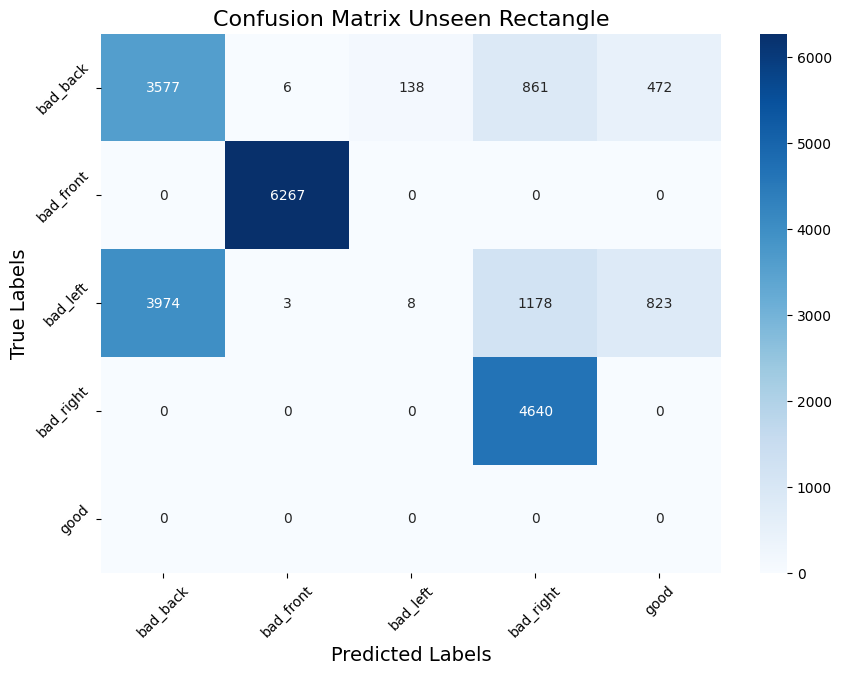

Classification Report:
              precision    recall  f1-score   support

    bad_back       0.47      0.71      0.57      5054
   bad_front       1.00      1.00      1.00      6267
    bad_left       0.05      0.00      0.00      5986
   bad_right       0.69      1.00      0.82      4640
        good       0.00      0.00      0.00         0

    accuracy                           0.66     21947
   macro avg       0.44      0.54      0.48     21947
weighted avg       0.56      0.66      0.59     21947



In [ ]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(labels_categorical, axis=1)

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Unseen Rectangle", fontsize= 16)
# Adding labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
# Rotate the x and y labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print("Classification Report:")
print(report)

In [ ]:
folder_path = '/content/drive/MyDrive/Research/Unseen Data Ellipse'
first, second, third = read_csv_files(exclude_cols = ['Time (s)', 'Label'], baseline = 0.6, folder_path=folder_path)

<Axes: xlabel='Label'>

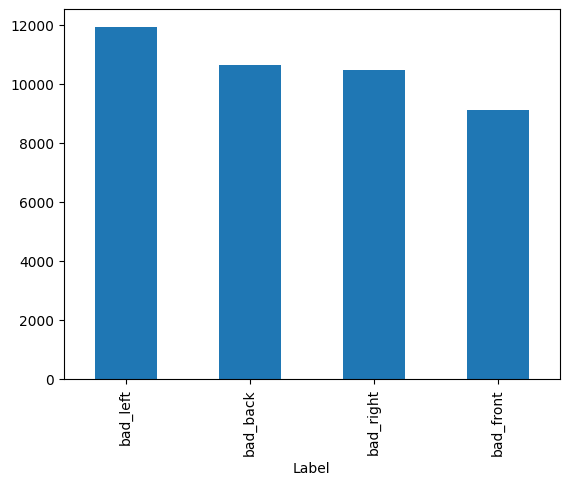

In [ ]:
first.Label.value_counts().plot(kind='bar')

In [ ]:
X_unseen = np.array(first['Image'].tolist())
Y_unseen = first["Label"]
labels_encoded = label_encoder.fit_transform(Y_unseen)
labels_categorical = to_categorical(labels_encoded)

y_pred_prob = model.predict(X_unseen.reshape(-1, 3, 5, 1))  # Predicted probabilities


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


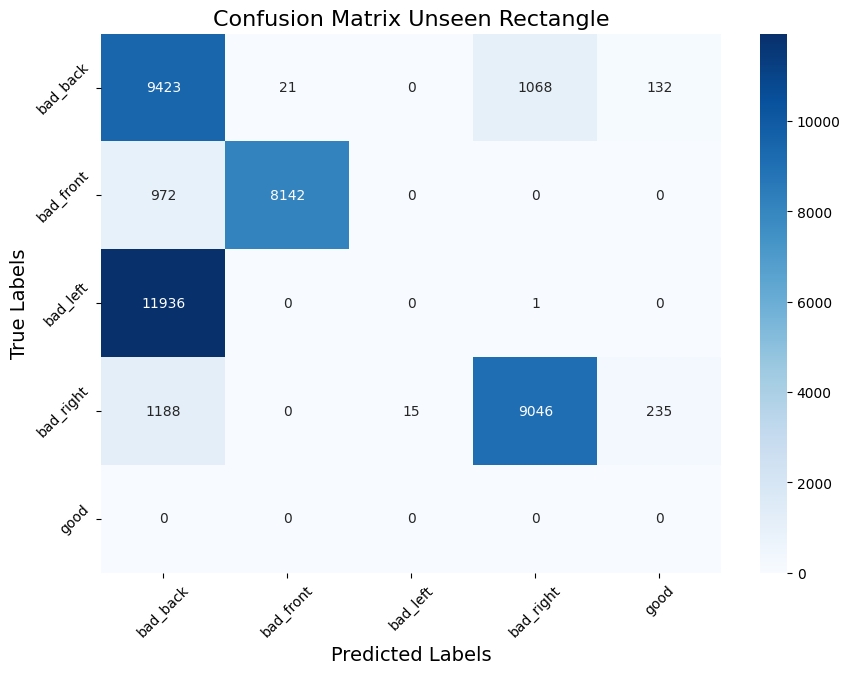

Classification Report:
              precision    recall  f1-score   support

    bad_back       0.40      0.89      0.55     10644
   bad_front       1.00      0.89      0.94      9114
    bad_left       0.00      0.00      0.00     11937
   bad_right       0.89      0.86      0.88     10484
        good       0.00      0.00      0.00         0

    accuracy                           0.63     42179
   macro avg       0.46      0.53      0.47     42179
weighted avg       0.54      0.63      0.56     42179



In [ ]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(labels_categorical, axis=1)

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Unseen Ellipse", fontsize= 16)
# Adding labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
# Rotate the x and y labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print("Classification Report:")
print(report)

# Hyperparameter Tuning

In [ ]:
hypermodel = model

# Set up the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='my_project'
)

# Perform hyperparameter search
tuner.search(X, Y, epochs=10, validation_split=0.2)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print(f"Best hyperparameters: {best_hyperparameters.values}")

ValueError: Inputs to a layer should be tensors. Got '<keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7cad8230ff10>' (of type <class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>) as input for layer 'functional'.